In [1]:
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# Загрузка данных
data_train = pd.read_csv("train.csv")


In [2]:
TRAIN_SPLIT = int(0.9 * len(data_train))
print(TRAIN_SPLIT)

8091


In [3]:
data_train.head()

,DateTime,Robot_X,Robot_Y,Robot_Angle,Ball_X,Ball_Y
0,09.02.2024 21:48:28,-0.049646,0.111455,-0.015986,0.075607,1.46080
1,09.02.2024 21:48:28,-0.049646,0.111455,-0.015971,0.075707,1.46080
2,09.02.2024 21:48:28,-0.239089,1.040000,-0.015955,0.075873,1.46167
3,09.02.2024 21:48:28,-0.101059,1.058200,-0.004182,0.070520,1.33220
4,09.02.2024 21:48:28,-0.101053,1.058080,-0.004240,0.070281,1.33212


In [4]:
import torch

torch.manual_seed(13)

In [5]:
features_considered = ['Robot_X', 'Robot_Y', 'Robot_Angle', 'Ball_X', 'Ball_Y']
features = data_train[features_considered]
features.index = data_train['DateTime']
features.head()


,Robot_X,Robot_Y,Robot_Angle,Ball_X,Ball_Y
DateTime,,,,,
09.02.2024 21:48:28,-0.049646,0.111455,-0.015986,0.075607,1.46080
09.02.2024 21:48:28,-0.049646,0.111455,-0.015971,0.075707,1.46080
09.02.2024 21:48:28,-0.239089,1.040000,-0.015955,0.075873,1.46167
09.02.2024 21:48:28,-0.101059,1.058200,-0.004182,0.070520,1.33220
09.02.2024 21:48:28,-0.101053,1.058080,-0.004240,0.070281,1.33212


In [6]:
dataset = features.values
data_mean = dataset.mean(axis=0)
data_std = dataset.std(axis=0)


In [7]:
dataset = (dataset-data_mean)/data_std


In [8]:
# Приведенная ниже функция возвращает вышеописанные временные интервалы для обучения модели. 
# @param: history_size — это размер последнего временного интервала,
# target_size – аргумент, определяющий насколько далеко в будущее модель должна научиться прогнозировать.
#  Другими словами, target_size – это целевой вектор, который необходимо спрогнозировать.

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [9]:
# У нас, в среднем, 11-12 записей каждую секунду, то есть примерно раз в 83 миллисекунды. 
# Допустим, мы хотим прогнозировать на основе предыдущего измерения, положение тела в следующий момент

past_history  = 1
future_target = 1
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 0:2], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 0:2],
                                                TRAIN_SPLIT, None, past_history,
                                                future_target, STEP,
                                                single_step=True)

In [10]:
BATCH_SIZE = 128

from torch.utils.data import TensorDataset, DataLoader

# Создание датасета
train_data_single = TensorDataset(torch.tensor(x_train_single).float(), torch.tensor(y_train_single).float())

# Создание DataLoader
train_loader_single = DataLoader(train_data_single, batch_size=BATCH_SIZE, shuffle=True)

val_data_single = TensorDataset(torch.tensor(x_val_single).float(), torch.tensor(y_val_single).float())

# Создание DataLoader
val_loader_single = DataLoader(val_data_single, batch_size=BATCH_SIZE, shuffle=False)



In [11]:
import torch.nn as nn

class SingleStepModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
        super(SingleStepModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 2*hidden_size)
        self.bn1 = nn.BatchNorm1d(2*hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(2*hidden_size, output_size)

    def forward(self, x):
        # x: (batch_size, seq_len, input_size)
        _, (hidden, _) = self.rnn(x)
        # hidden: (1, batch_size, hidden_size)
        out = self.fc1(hidden.squeeze(0))
        out = self.bn1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out


# Определение модели
input_size = x_train_single.shape[-1]
hidden_size = 32
output_size = 2
single_step_model = SingleStepModel(input_size, hidden_size, output_size)

# Определение функции потерь и оптимизатора
criterion =  nn.MSELoss()
optimizer =  torch.optim.Adam(single_step_model.parameters(), lr=0.001)

/home/gukas/work/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/gukas/work/.venv/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [12]:
EPOCHS = 10

Epoch 1/10, Train Loss: 0.2366, Val Loss: 0.1200
Epoch 2/10, Train Loss: 0.1495, Val Loss: 0.0289
Epoch 3/10, Train Loss: 0.1382, Val Loss: 0.0279
Epoch 4/10, Train Loss: 0.1293, Val Loss: 0.0336
Epoch 5/10, Train Loss: 0.1229, Val Loss: 0.0289
Epoch 6/10, Train Loss: 0.1136, Val Loss: 0.0263
Epoch 7/10, Train Loss: 0.1101, Val Loss: 0.0267
Epoch 8/10, Train Loss: 0.1038, Val Loss: 0.0266
Epoch 9/10, Train Loss: 0.1035, Val Loss: 0.0262
Epoch 10/10, Train Loss: 0.1032, Val Loss: 0.0247


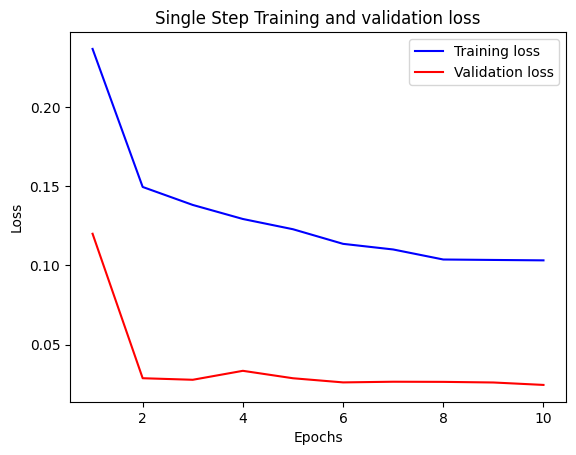

In [13]:
import torch
import matplotlib.pyplot as plt

import copy 

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_weights = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, targets in train_loader:
            inputs = inputs.float()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.float()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item() * inputs.size(0)
            epoch_val_loss = running_val_loss / len(val_loader.dataset)
            val_losses.append(epoch_val_loss)
        
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                best_model_weights = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')
    
    model.load_state_dict(best_model_weights)

    return train_losses, val_losses

def plot_train_history(train_losses, val_losses, title):
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

train_losses, val_losses = train_model(single_step_model, train_loader_single, val_loader_single, criterion, optimizer, EPOCHS)
plot_train_history(train_losses, val_losses, 'Single Step Training and validation loss')

In [14]:
def predict(model, input_data):
    model.eval()

    with torch.no_grad():
        output = model(input_data)
    
    return output

In [93]:
data_test  = pd.read_csv("test.csv")
test_data = data_test[features_considered]
test_data.index = data_test['DateTime']
test_data = data_test[features_considered]
test_data.index = data_test['DateTime']
test_dataset = test_data.values
test_dataset = (test_dataset - data_mean) / data_std

x_test_single, y_test_single = multivariate_data(test_dataset, test_dataset[:, 0:2],
                                                0, None, past_history,
                                                future_target, STEP,
                                                single_step=True)


test_data_single = TensorDataset(torch.tensor(x_test_single).float(), torch.tensor(y_test_single).float())
test_loader_single = DataLoader(test_data_single, batch_size=BATCH_SIZE, shuffle=False)


nn_errors = []

def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.float()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
    avg_loss = total_loss / len(test_loader.dataset)
    return avg_loss

# Assuming test_loader_single contains the test data
test_loss = evaluate_model(single_step_model, test_loader_single, criterion)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.0771


Итак, РНС выдала на тестовой выборке MSE в 0.0771. Теперь посмотрим на линейный алгоритм:


In [94]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X = data_train.iloc[:-1][['Robot_X', 'Robot_Y', 'Robot_Angle', 'Ball_X', 'Ball_Y']]
y = data_train.iloc[1:][['Robot_X', 'Robot_Y']]

# Вычисление среднего и стандартного отклонения для каждого признака
means = X.mean(axis=0)
stds = X.std(axis=0)

# Нормировка данных
X_scaled = (X - means) / stds

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.9, random_state=42)



In [95]:
import numpy as np

class LinearRegression:
    def __init__(self):
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):
        # Добавляем столбец единиц к матрице признаков для учета свободного коэффициента (intercept)
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        
        # Решаем уравнение коэффициентов: (X^T * X)^(-1) * X^T * y
        self.theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

        # Первый элемент theta - intercept, остальные - коэффициенты при признаках
        self.intercept_ = self.theta[0]
        self.coef_ = self.theta[1:]

    def predict(self, X):
        # Добавляем столбец единиц к матрице признаков для учета свободного коэффициента (intercept)
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        
        # Предсказываем значения y: y = X * theta
        y_pred = X.dot(self.theta)
        return y_pred

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.15186235024258338


In [96]:
X_test = data_test.iloc[:-1][['Robot_X', 'Robot_Y', 'Robot_Angle', 'Ball_X', 'Ball_Y']]
y_test = data_test.iloc[1:][['Robot_X', 'Robot_Y']]

X_test = (X_test - means) / stds
y_test_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_test_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 0.19787439754216304


Как видим, реккурентная нейронная сеть справляется с задачей прогнозирования следующего шага куда лучше, чем классические алгоритмы регресии.